In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd './drive/My Drive/Movie_lens/'

/content/drive/My Drive/Movie_lens


## **0. 加载包**

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from operator import itemgetter

## **1. Data Preparing**

### 1.1 将评分数据按照80%, 10%, 10%的比例划分为训练集，验证集和测试集

In [12]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')

ratings.sample(frac=1.0)
train_set, test_set = train_test_split(ratings,test_size = 0.2)
dev_set, test_set = train_test_split(test_set,test_size = 0.5)
train_set = np.array(train_set, dtype = 'int')
dev_set = np.array(dev_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [5]:
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
print(train_set.shape)
print(dev_set.shape)
print(test_set.shape)

(800167, 4)
(100021, 4)
(100021, 4)


### 1.2 将数据转化列表形式（[ [用户1对所有电影的评分], [用户2对所有电影的评分] ...]，并把用户未打分的电影的评分设为0

In [13]:
nb_users = int(max(max(train_set[:,0]), max(dev_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(train_set[:,1]), max(dev_set[:,1]), max(test_set[:,1])))

# Converting the data into an array with users in lines and movies in columns
def convert(data):
    new_data = []
    #匹配相对应的 local data里面 user与movie相匹配，若user没有评价过该movie，then mark ‘0’
    for id_users in range(1, nb_users + 1):
        #create 第一层list，id_movies为某user看过的movie的id
        id_movies = data[:,1][data[:,0] == id_users]
        #id_ratings为某user评价过某movie的rate
        id_ratings = data[:,2][data[:,0] == id_users]
        #首先创建全部为0的list，再将user 评价movie的rating分数替换0，那么就能mark user没看过的movie为0
        ratings = np.zeros(nb_movies)
        #由于movieID由1开始，而python由0开始，因此要rating匹配python则-1
        ratings[id_movies - 1] = id_ratings
        #将以上创建的list合并到一个list，以被torch提取
        new_data.append(list(ratings))
    return new_data
    
train_set = convert(train_set)
dev_set = convert(dev_set)
test_set = convert(test_set)

### 1.3 数据载入pytorch自带的DataLoader

In [15]:
train_set = torch.FloatTensor(train_set)
train_set = train_set[torch.sum(train_set!=0,axis=1)!=0] # 删除评分全为0的行
dev_set = torch.FloatTensor(dev_set)
dev_set = dev_set[torch.sum(dev_set!=0,axis=1)!=0] # 删除评分全为0的行
test_set = torch.FloatTensor(test_set)
test_set = test_set[torch.sum(test_set!=0,axis=1)!=0] # 删除评分全为0的行

train_dataset = TensorDataset(train_set)
dev_dataset = TensorDataset(dev_set)
test_dataset = TensorDataset(test_set)

train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
dev_loader = DataLoader(dataset = dev_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

## **2. Auto Encoder**

### 2.1 定义模型和损失函数

In [10]:
class AE(nn.Module):
  """
  Auto Encoder(AE)最初用于学习数据的表示(编码)。其可被分解为两部分:

  encoder：减少了数据的维度大小;
  decoder：它将编码转换回其原始形式。由于存在降维，神经网络需要学习输入(潜在空间)的低维表示，以便能够重构输入。

  它们可以用来预测新的推荐。为了做到这一点，输入和输出都是点击向量(通常AE的输入和输出是相同的)，我们将在输入层之后使用大的dropout。
  这意味着模型将不得不重构点击向量，因为输入中的某个元素将会丢失，因此要学会预测给定的点击向量的推荐值。
  """
  def __init__(self, nb_movies, device="cuda:0"):
    super(AE, self).__init__()
    self.nb_movies = nb_movies
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_movies, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9), # 这里需要一个大的dropout
        nn.Linear(512, 80),
        nn.Sigmoid(),
        nn.Linear(80, 32),
        nn.Sigmoid()
        )
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_movies)
        )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

def loss_func(recon_x, x):
  """
  对于一个用户而言，他只对部分电影进行了打分，因此在计算MSE时，只考虑他打过分的电影，而忽略他没打过分的电影
  这里MSE的计算原理是，例如2个用户对5个电影的打分数据为：[[1, 2, 0, 3, 4], [2, 3, 0, 0, 1]]
  经过AE重构后的打分数据为：[[1.1, 2.3, 0, 3.3, 4.7], [2.1, 3.2, 0, 0, 1.2]]
  则先计算两打分数据的2范数的平方，再除以每个用户打过分的电影数，得到每个用户的MSE，再用torch.mean求平均得到每个batch的MSE
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  return MSE

### 2.2 定义训练，验证和测试函数

In [23]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  ae.train()
  total_loss = 0
  for _, data in enumerate(train_loader, 0):
    data = Variable(data[0]).to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x = ae.forward(data)
    # 在优化过程中，我们只想考虑用户打过分的电影，
    # 虽然我们之前将用户未打分的电影的评分设为0，但是我们还需要将模型预测的用户未打分的电影的评分也设为0，
    # 这样才不会累加到loss里导致影响了权重更新
    recon_x[target == 0] = 0 
    loss = loss_func(recon_x, data)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    ae.eval()
    total_loss = 0
    with torch.no_grad():
      for _, data in enumerate(dev_loader, 0):
        data = Variable(data[0]).to(device)
        target = data.clone()
        recon_x = ae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

def test(test_loader, device="cuda:0"):
  ae.eval()
  total_loss = 0
  with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
      data = Variable(data[0]).to(device)
      target = data.clone()
      recon_x = ae.forward(data)
      recon_x[target == 0] = 0
      loss = loss_func(recon_x, data)
      total_loss += loss.item()
  print('Average test loss: {:.4f}'.format(total_loss / len(test_loader)))

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  ae = AE(nb_movies = nb_movies).to(device)
  optimizer =  optim.Adam(ae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 200
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = dev_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)
  print("\n", 20 * "=", "Testing Auto Encoder on device: {}".format(device), 20 * "=")
  test(test_loader)


 ==================== Training Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 3.8287, Validating Average loss: 1.0679
====> Epoch: 2 Training Average loss: 1.0207, Validating Average loss: 1.0108
====> Epoch: 3 Training Average loss: 0.9985, Validating Average loss: 1.0099
====> Epoch: 4 Training Average loss: 0.9965, Validating Average loss: 1.0129
====> Epoch: 5 Training Average loss: 0.9960, Validating Average loss: 1.0109
====> Epoch: 6 Training Average loss: 0.9957, Validating Average loss: 1.0121
====> Epoch: 7 Training Average loss: 0.9961, Validating Average loss: 1.0124
====> Epoch: 8 Training Average loss: 0.9954, Validating Average loss: 1.0130
====> Epoch: 9 Training Average loss: 0.9946, Validating Average loss: 1.0126
====> Epoch: 10 Training Average loss: 0.9934, Validating Average loss: 1.0098
====> Epoch: 11 Training Average loss: 0.9924, Validating Average loss: 1.0138
====> Epoch: 12 Training Average loss: 0.9907, Validatin

### 2.3 保存与加载模型

In [ ]:
# save the training model
torch.save(ae.state_dict(), 'AutoEncoder.pkl')

# load the trained model
ae = torch.load('AutoEncoder.pkl')

### 2.4 画图展示训练和验证过程中的loss变化情况：可以发现验证集的loss出现了先下降后微升的情况，考虑是模型过拟合+泛化能力差

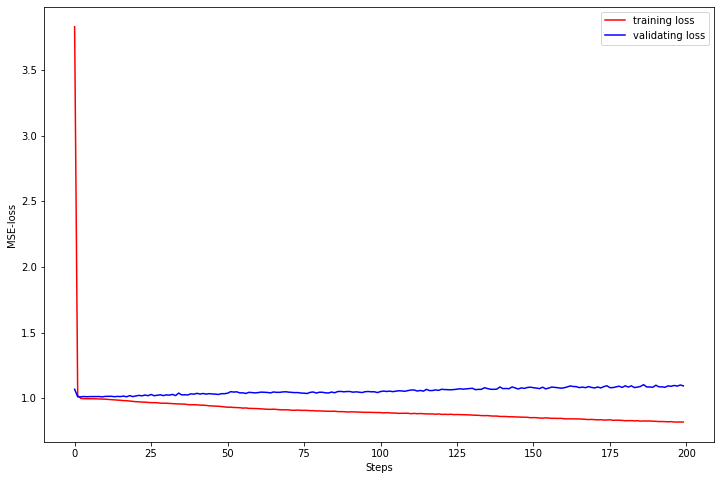

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.legend()

## **3. Variational Auto Encoder**

### 3.1 定义模型和损失函数

In [25]:
class VAE(nn.Module):

  def __init__(self, nb_movies, device="cuda:0"):
    super(VAE, self).__init__()
    self.nb_movies = nb_movies
    self.encoder = nn.Sequential(
        nn.Linear(self.nb_movies, 512),
        nn.Sigmoid(),
        nn.Dropout(0.9), # 需要一个较大的dropout
        nn.Linear(512, 80),
        nn.Sigmoid()
        )
    self.fc1 = nn.Linear(80, 32)
    self.fc2 = nn.Linear(80, 32)
    self.decoder = nn.Sequential(
        nn.Linear(32, 80),
        nn.Sigmoid(),
        nn.Linear(80, 512),
        nn.Sigmoid(),
        nn.Linear(512, self.nb_movies)
        )
    
  # reparameterize
  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size(0), mu.size(1))).to(device)
    z = mu + eps * torch.exp(logvar/2) 
    return z

  def forward(self, x):
    out1, out2 = self.encoder(x), self.encoder(x)
    mu = self.fc1(out1)
    logvar = self.fc2(out2)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

def loss_func(recon_x, x, mu, logvar):
  """
  VAE的损失包括两部分：
  一部分是预测结果和真实结果的平均绝对误差；
  另一部分是KL-divergence（KL散度），用来衡量潜在变量的分布和单位高斯分布的差异。
  """
  MSE = torch.mean(torch.norm((x - recon_x), p=2, dim=1, keepdim=False)**2/torch.sum(recon_x!=0,axis=1))
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD

### 3.2 定义训练，验证和测试函数

In [26]:
def train(train_loader, dev_loader=None, is_validate=True, device="cuda:0"):
  vae.train()
  total_loss = 0
  for _, data in enumerate(train_loader, 0):
    data = Variable(data[0]).to(device)
    target = data.clone()
    optimizer.zero_grad()
    recon_x, mu, logvar = vae.forward(data)
    recon_x[target == 0] = 0
    loss = loss_func(recon_x, data, mu, logvar)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    epoch_train_loss = total_loss / len(train_loader)

  if (is_validate == True):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
      for _, data in enumerate(dev_loader, 0):
        data = Variable(data[0]).to(device)
        target = data.clone()
        recon_x, mu, logvar = vae.forward(data)
        recon_x[target == 0] = 0
        loss = loss_func(recon_x, data, mu, logvar)
        total_loss += loss.item()
        epoch_dev_loss = total_loss / len(dev_loader)
    print('====> Epoch: {} Training Average loss: {:.4f}, Validating Average loss: {:.4f}'.format(epoch, epoch_train_loss, epoch_dev_loss))
    return epoch_train_loss, epoch_dev_loss

  else:
    print('====> Epoch: {} Training Average loss: {:.4f}'.format(epoch, epoch_train_loss))
    return epoch_train_loss

def test(test_loader, device="cuda:0"):
  vae.eval()
  total_loss = 0
  with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
      data = Variable(data[0]).to(device)
      target = data.clone()
      recon_x, mu, logvar = vae.forward(data)
      recon_x[target == 0] = 0
      loss = loss_func(recon_x, data, mu, logvar)
      total_loss += loss.item()
  print('Average test loss: {:.4f}'.format(total_loss / len(test_loader)))

if __name__ == "__main__":
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  vae = VAE(nb_movies = nb_movies).to(device)
  optimizer =  optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  EPOCH = 200
  epoches_train_loss = []
  epoches_dev_loss = []

  print("\n", 20 * "=", "Training Variational Auto Encoder on device: {}".format(device), 20 * "=")
  for epoch in range(1, EPOCH + 1):
    epoch_train_loss, epoch_dev_loss = train(train_loader, dev_loader = dev_loader)
    epoches_train_loss.append(epoch_train_loss)
    epoches_dev_loss.append(epoch_dev_loss)
  print("\n", 20 * "=", "Testing Variational Auto Encoder on device: {}".format(device), 20 * "=")
  test(test_loader)


 ==================== Training Variational Auto Encoder on device: cuda:0 ====================
====> Epoch: 1 Training Average loss: 7.4468, Validating Average loss: 1.4327
====> Epoch: 2 Training Average loss: 1.9506, Validating Average loss: 1.2280
====> Epoch: 3 Training Average loss: 1.4592, Validating Average loss: 1.0943
====> Epoch: 4 Training Average loss: 1.2420, Validating Average loss: 1.0396
====> Epoch: 5 Training Average loss: 1.1448, Validating Average loss: 1.0240
====> Epoch: 6 Training Average loss: 1.0957, Validating Average loss: 1.0269
====> Epoch: 7 Training Average loss: 1.0674, Validating Average loss: 1.0248
====> Epoch: 8 Training Average loss: 1.0468, Validating Average loss: 1.0277
====> Epoch: 9 Training Average loss: 1.0347, Validating Average loss: 1.0238
====> Epoch: 10 Training Average loss: 1.0244, Validating Average loss: 1.0253
====> Epoch: 11 Training Average loss: 1.0172, Validating Average loss: 1.0253
====> Epoch: 12 Training Average loss: 1.011

### 3.3 画图展示训练和验证过程中的loss变化情况，发现虽然VAE的training loss比AE大，但是validating loss和test loss小于AE。考虑是因为VAE的training loss包含了两部分，因而training loss偏大；但VAE模型可能捕捉到了数据中更复杂的模式，使得在验证集和测试集上有更好的表现。 

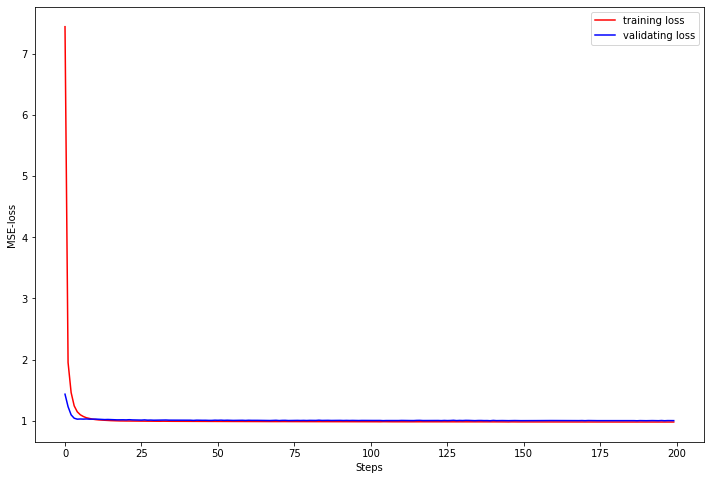

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(np.arange(len(epoches_train_loss)), epoches_train_loss, color='r', label='training loss')
plt.plot(np.arange(len(epoches_dev_loss)), epoches_dev_loss, color='b', label='validating loss')
plt.xlabel('Steps')
plt.ylabel('MSE-loss')
plt.legend()

## **4. 利用模型对用户未评分的电影进行预测，根据预测分值，对用户推荐他没看过的电影**

### 4.1 定义预测函数

In [35]:
#prediction
def Prediction(model, movies, user_id, nb_recommend):
    user_input = Variable(test_set[user_id - 1]).unsqueeze(0).to(device)
    predict_output, _, _ = model.forward(user_input)
    predict_output = predict_output.cpu().detach().numpy()
    user_input = user_input.cpu().detach().numpy()
    predicted_result = np.vstack([user_input, predict_output])
    recommend = np.array(predicted_result)
    trian_movie_id = np.array([i for i in range(1, nb_movies+1)])#create a temporary index for movies since we are going to delete some movies that the user had seen, 创建一个类似id的index，排序用
    recommend = np.row_stack((recommend, trian_movie_id))#insert that index into the result array, 把index插入结果
    recommend = recommend.T#transpose row and col 数组的行列倒置
    recommend = recommend.tolist()#tansfer into list for further process转化为list以便处理

    movie_not_seen = []#delete the rows comtaining the movies that the user had seen 删除users看过的电影
    for i in range(len(recommend)):
        if recommend[i][0] == 0.0:
            movie_not_seen.append(recommend[i])

    movie_not_seen = sorted(movie_not_seen, key=itemgetter(1), reverse=True)#sort the movies by mark 按照预测的分数降序排序

    recommend_movie = []#create list for recommended movies with the index we created 推荐的top20
    for i in range(0, nb_recommend):
        recommend_movie.append(movie_not_seen[i][2])

    recommend_index = []#get the real index in the original file of 'movies.dat' by using the temporary index这20部电影在原movies文件里面真正的index
    for i in range(len(recommend_movie)):
        recommend_index.append(movies[(movies.iloc[:,0]==recommend_movie[i])].index.tolist())

    recommend_movie_name = []#get a list of movie names using the real index将对应的index输入并导出movie names
    for i in range(len(recommend_index)):
        np_movie = movies.iloc[recommend_index[i],1].values#transefer to np.array
        list_movie = np_movie.tolist()#transfer to list
        recommend_movie_name.append(list_movie)

    print('Highly Recommended Moives for You:\n')
    for i in range(len(recommend_movie_name)):
        print(str(recommend_movie_name[i]))
    
    return recommend_movie_name

### 4.2 对指定用户，从他没看过的电影中推荐他最可能喜欢的几部电影

In [36]:
# 指定用户的ID
user_id = 367
# 指定推荐的电影数目
nb_recommend = 20
# 读取原电影数据以便在推荐时查询
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
# 使用VAE模型进行预测推荐
movie_for_you = Prediction(model = vae, movies = movies, user_id = user_id, nb_recommend = nb_recommend)

Highly Recommended Moives for You:

['Ulysses (Ulisse) (1954)']
['Song of Freedom (1936)']
['Paralyzing Fear: The Story of Polio in America, A (1998)']
['Gate of Heavenly Peace, The (1995)']
['Mamma Roma (1962)']
['Skipped Parts (2000)']
['Window to Paris (1994)']
['Lamerica (1994)']
['24 7: Twenty Four Seven (1997)']
['Lured (1947)']
['Smashing Time (1967)']
['Seven Chances (1925)']
['I Am Cuba (Soy Cuba/Ya Kuba) (1964)']
['Follow the Bitch (1998)']
['Baby, The (1973)']
['Firelight (1997)']
['Apple, The (Sib) (1998)']
['Eighth Day, The (Le Huitième jour ) (1996)']
['Time of the Gypsies (Dom za vesanje) (1989)']
['Message to Love: The Isle of Wight Festival (1996)']
